## Kickstarter Predictions - EDA
### Machine Learning Project - October 2023

---

### TOC (table of content) <a name="TOC"></a>

01. [About this file](#1)
02. [Import Packages & Data](#2)
03. [EDA - Overview](#3)
04. [Outlier Exploration](#4)
05. [Visualisation](#5)
06. [Data Preparation](#6)
07. [Data Insights](#7)
08. [Research Questions](#8)
09. [Research Results](#9)

---

### 01. About this file <a name="1"></a>

[TOC](#TOC)

Kickstarter is a popular crowdfunding platform that has helped thousands of entrepreneurs and creators bring their innovative ideas to life. However, not all Kickstarter projects are successful, and understanding the factors that contribute to success or failure can be valuable for both creators and investors alike.

In this dataset, we have collected information on a large number of Kickstarter projects and whether they ultimately succeeded or failed to meet their funding goals. This dataset includes a wide range of project types, including technology startups, creative arts endeavors, and social impact initiatives, among others.

By analyzing this dataset, researchers and analysts can gain insights into the characteristics of successful and unsuccessful Kickstarter projects, such as funding targets, project categories, and funding sources. This information can be used to inform investment decisions and guide future crowdfunding campaigns.

Overall, this dataset provides a comprehensive look at the Kickstarter ecosystem and can serve as a valuable resource for anyone interested in understanding the dynamics of crowdfunding and the factors that contribute to project success or failure.

---

### 02. Import Packages & Data <a class="anchor" id="2"></a>

[TOC](#TOC)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import pandas as pd

In [2]:
df = pd.read_csv('data/kickstarter_projects.csv')

---

### 03. EDA - Overview <a class="anchor" id="3"></a>

[TOC](#TOC)

In [3]:
df.shape

(374853, 11)

In [4]:
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


### Column description

| Column       | Meaning                                   |
|-------------- |-----------------------------------------|
| ID           | ID                                       |
| Name         | Name                                     |
| Category     | Category                                 |
| Subcategory  | Subcategory                              |
| Country      | Country of product origin               |
| Launched     | Date the project was launched            |
| Deadline     | Deadline for crowdfunding                |
| Goal         | Amount of money the creator needs (USD) |
| Pledged      | Amount of money pledged by the crowd (USD) |
| Backers      | Number of backers                        |
| State        | Current project status (as of 2018-01-02) |

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,ID,Goal,Pledged,Backers
count,3.748530e+05,3.748530e+05,3.748530e+05,374853.000000
mean,1.074656e+09,4.586378e+04,9.121073e+03,106.690359
std,6.191377e+08,1.158778e+06,9.132054e+04,911.718520
min,5.971000e+03,0.000000e+00,0.000000e+00,0.000000
25%,5.380728e+08,2.000000e+03,3.100000e+01,2.000000
50%,1.075300e+09,5.500000e+03,6.250000e+02,12.000000
75%,1.610149e+09,1.600000e+04,4.051000e+03,57.000000
max,2.147476e+09,1.663614e+08,2.033899e+07,219382.000000


In [8]:
df['State'].value_counts()

State
Failed        197611
Successful    133851
Canceled       38751
Live            2798
Suspended       1842
Name: count, dtype: int64

In [9]:
df.State.value_counts() / len(df) * 100

State
Failed        52.716932
Successful    35.707597
Canceled      10.337652
Live           0.746426
Suspended      0.491393
Name: count, dtype: float64

Status of projects:
- Failed: 52.7% 
- Successful: 35.7%
- Canceled + Live + Suspended: 10.6%

Definition of `States`:
- Failed: Goal < Pledged
- Successful: Goal >= Pledged
- Canceled: canceled by kickstarter founder
- Suspended: suspended by kickstarter
- Live: campaign still ongoing


In [10]:
df.Country.value_counts() / len(df) * 100

Country
United States     78.062067
United Kingdom     8.982454
Canada             3.936476
Australia          2.091220
Germany            1.112703
France             0.784041
Italy              0.767768
Netherlands        0.765100
Spain              0.607171
Sweden             0.468717
Mexico             0.467383
New Zealand        0.386018
Denmark            0.296916
Ireland            0.216351
Switzerland        0.202746
Norway             0.188874
Hong Kong          0.164865
Belgium            0.164598
Austria            0.159262
Singapore          0.148058
Luxembourg         0.016540
Japan              0.010671
Name: count, dtype: float64

Highly imbalanced data: 
- 78% US
- 8% UK
- rest < 4%

---

### 04. Outlier Exploration <a class="anchor" id="4"></a>

[TOC](#TOC)

In [11]:
df.query("State == 'Successful' and Goal > Pledged")

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
258920,1769772834,Borders of the Imagination - An Epic Sci-Fi/Fa...,Film & Video,Shorts,United States,2015-11-12 19:06:18,2015-12-27,36000,30716,275,Successful
272350,780863434,TUW Ruhla Watches - Comeback of a Legend,Design,Product Design,Germany,2016-02-08 19:14:02,2016-03-19,27885,27765,90,Successful


Two cases where the campaign was `Successful` although `Pledged < Goal`.

In [12]:
df.query("State == 'Failed' and Goal < Pledged")

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
2295,2103203254,The new face of Canadian Science Fiction,Publishing,Fiction,United States,2010-03-18 04:35:31,2010-05-16,10000,10797,66,Failed
33823,1297794474,Music Empowers - A Day with the Accende Ensemble,Music,Classical Music,United States,2011-11-07 15:20:24,2012-01-04,3000,3088,20,Failed
86441,1085047405,"""Balance""",Music,Jazz,United States,2013-03-05 10:55:56,2013-04-04,23000,23020,141,Failed
108392,59246799,Key Wrench - Unlock Your Life!,Design,Product Design,United States,2013-08-24 05:42:10,2013-10-04,6000,6183,208,Failed


4 cases where the campaign was `Failed` although `Goal > Pledged`.

In [13]:
df.query("State == 'Canceled' and Goal < Pledged").shape[0]

648

648 canceled campaigns before Goal was achieved.

In [14]:
df.query("State == 'Successful' and Goal > 1_000_000")

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
68784,458565935,Project Eternity,Games,Video Games,United States,2012-09-14 19:01:04,2012-10-17,1100000,3986929,73986,Successful
74269,880009511,Elite: Dangerous,Games,Video Games,United Kingdom,2012-11-06 01:00:57,2013-01-05,2015609,2545014,25681,Successful
87484,1755266685,The Veronica Mars Movie Project,Film & Video,Narrative Film,United States,2013-03-13 15:42:22,2013-04-13,2000000,5702153,91585,Successful
90001,1682353635,Camelot Unchained,Games,Video Games,United States,2013-04-02 17:56:11,2013-05-02,2000000,2232933,14873,Successful
92941,1871494789,WISH I WAS HERE,Film & Video,Narrative Film,United States,2013-04-24 11:57:04,2013-05-24,2000000,3105473,46520,Successful
104397,1567218706,The Newest Hottest Spike Lee Joint,Film & Video,Narrative Film,United States,2013-07-22 18:15:41,2013-08-21,1250000,1418910,6421,Successful
115172,1719494931,Obduction,Games,Video Games,United States,2013-10-17 15:06:31,2013-11-16,1100000,1321306,22195,Successful
138030,721748605,Blue Mountain State: The Movie,Film & Video,Narrative Film,United States,2014-04-15 14:43:13,2014-05-15,1500000,1911827,23999,Successful
227382,788486889,The Bards Tale IV,Games,Video Games,United States,2015-06-02 14:57:26,2015-07-11,1250000,1519681,33741,Successful
230354,947809001,Shenmue 3,Games,Video Games,United States,2015-06-16 03:51:04,2015-07-18,2000000,6333296,69320,Successful


Few successful campaigns with the Goal above 1 Mio.

In [15]:
df.query("State == 'Failed' and Goal > 100_000_000")

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
151823,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,United Kingdom,2014-07-09 00:24:34,2014-08-08,166361391,0,0,Failed
240492,219702078,Kitchen from Austria in Switzerland,Food,Restaurants,Switzerland,2015-08-06 19:12:10,2015-10-05,104057190,0,0,Failed
243902,944541075,Hydroponic's Skyscraper(un gratte-ciel hydropo...,Technology,Technology,France,2015-08-25 23:52:30,2015-10-24,110169772,2,2,Failed
259693,2000749004,A Celtic Lovestory,Film & Video,Drama,United Kingdom,2015-11-17 00:47:15,2015-11-30,151395870,0,0,Failed
324187,2132015082,DER NEANDERTALER (Kinofilm mit Starbesetzung i...,Film & Video,Movie Theaters,Germany,2017-01-13 20:08:41,2017-03-14,107369868,39,2,Failed


Few Failed campaigns with a goal above 100 Mio.

---

### 05. Data Visualisation <a class="anchor" id="5"></a>

[TOC](#TOC)

<Axes: ylabel='Category'>

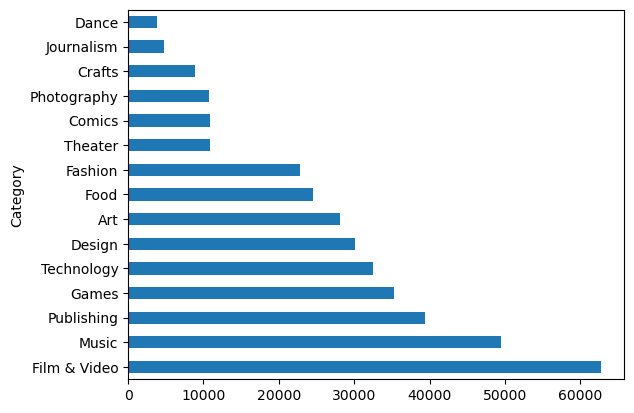

In [16]:
# CAMPAIGNS PER CATEGORY

(df['Category'].value_counts().plot(kind='barh'))

<Figure size 1200x800 with 0 Axes>

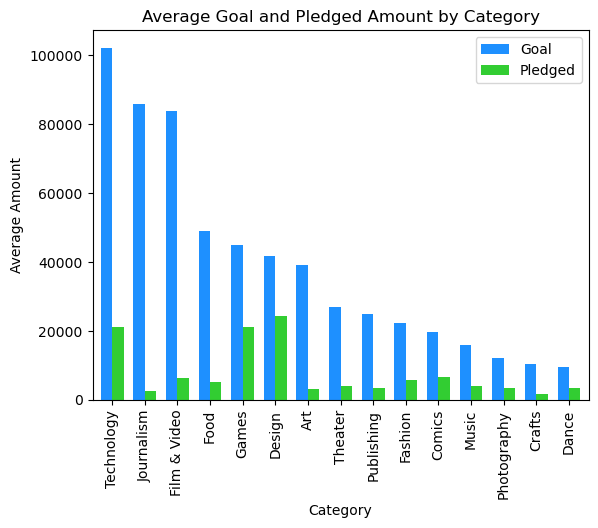

In [17]:
# AVERAGE GOAL VS. PLEDGED PER CATEGORY

# Group by Category and calculate the mean of the 'Goal' and 'Pledged' columns
goal_pledged_by_category = df.groupby('Category')[['Goal', 'Pledged']].mean()

# Sort the values to display in a more meaningful order
goal_pledged_by_category = goal_pledged_by_category.sort_values(by='Goal', ascending=False)

# Plot the goal and pledged amounts by category
plt.figure(figsize=(12, 8))
ax = goal_pledged_by_category.plot(kind='bar', color=['dodgerblue', 'limegreen'], width=0.7, position=0.5)

plt.title('Average Goal and Pledged Amount by Category')
plt.xlabel('Category')
plt.ylabel('Average Amount')
plt.xticks(rotation=90)
plt.legend(['Goal', 'Pledged'])
plt.show()

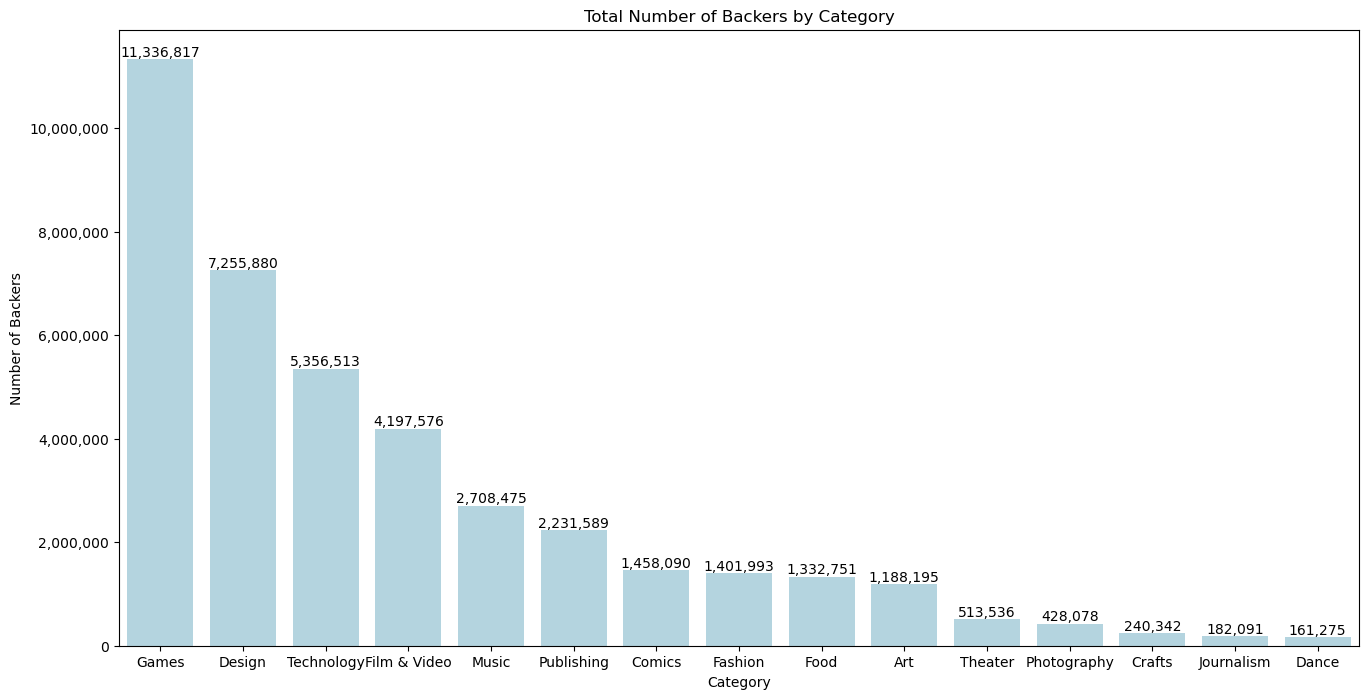

In [18]:
# AMOUNT OF BACKERS PER CATEGORY

backers_by_category = df.groupby('Category')['Backers'].sum().reset_index()
fig = plt.figure(figsize=(16, 8))
backers_by_category = backers_by_category.sort_values(by='Backers', ascending=False).reset_index()

# Create a bar plot using Seaborn
sns.barplot(x='Category', y='Backers', data=backers_by_category, color='lightblue')

# Set the title and axis labels
plt.title('Total Number of Backers by Category')
plt.xlabel('Category')
plt.ylabel('Number of Backers')

# Format y-axis ticks to show the actual number of backers
def format_ticks(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add total number of backers on top of each bar
for index, row in backers_by_category.iterrows():
    plt.annotate(f'{int(row["Backers"]):,}', xy=(index, row['Backers']), ha='center', va='bottom')

# Show the plot
plt.show()
plt.show()

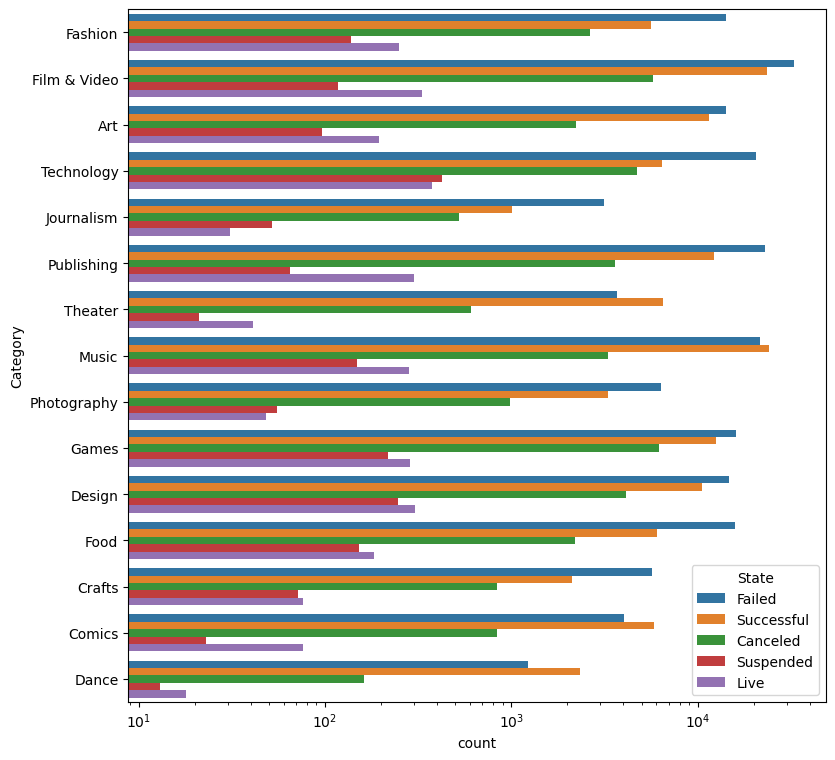

In [19]:
# STATE PER CATEGORY

plt.figure(figsize=(9, 9))
sns.countplot(df, y='Category', hue='State')
plt.xscale('log')

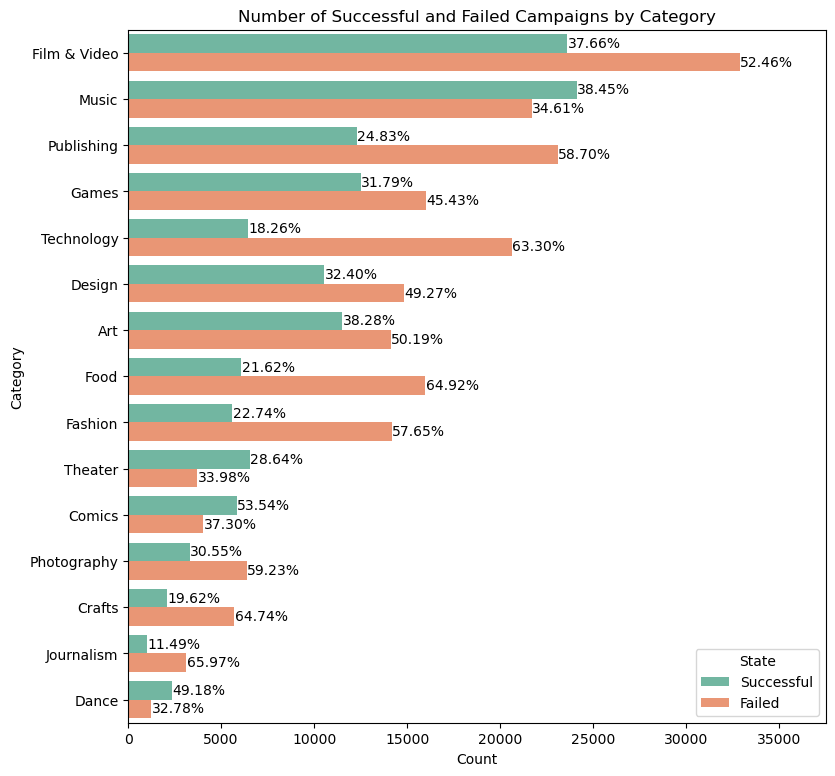

In [20]:
# SUCCESSFUL VS FAILED PER CATEGORY

order = df['Category'].value_counts().index
hue_order = ['Successful', 'Failed']

plt.figure(figsize=(9, 9))
ax = sns.countplot(df, y='Category', hue='State', palette='Set2', hue_order=hue_order, order=order)

# Calculate the relative percentages for each category
category_counts = df['Category'].value_counts()
for p in ax.patches:
    width = p.get_width()
    category = p.get_y()
    ax.text(width + 20, category + p.get_height() / 2, f'{width / category_counts[order[int(category)]]:.2%}', ha='left', va='center')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Number of Successful and Failed Campaigns by Category')
plt.xlim(0, 37500)

plt.legend(title='State', labels=['Successful', 'Failed'])
plt.show()


---

### 06. Data Preparation <a class="anchor" id="6"></a>

[TOC](#TOC)

The following function to prepare the dataset for modelling is already positioned here as we need the new dataframe for exploring our Research questions - see [Research Questions](#8) - Success vs. Name (length).

The function will be called in the 2nd notebook (ML_Model) at the beginning, too.

In [21]:
# FUNCTION TO PREPARE DATA FOR MODELLING

def prepare_data(dataframe):
    dataframe_new = dataframe.copy()
    # extract duration
    dataframe_new["Launched"] = pd.to_datetime(dataframe_new["Launched"])
    dataframe_new["Deadline"] = pd.to_datetime(dataframe_new["Deadline"])
    dataframe_new["Duration_days"] = (dataframe_new["Deadline"] - dataframe_new["Launched"]).dt.days
    # extract month / year
    dataframe_new["Month"] = dataframe_new["Launched"].dt.month
    # drop 'State' == 'Other' (Canceled, Suspended and Live)
    dataframe_new = dataframe_new.query("State == 'Successful' or State == 'Failed'")
    # drop specific categories (?)
    # dataframe_new = dataframe_new.query("Category != '...' and Category != '...'")
    # Combine 'Category' and 'Subcategory' (to not loose correlation)
    dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
    categories = ["Category", "Subcategory", "Country", "State", "Combined_category"]
    dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
        dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]].astype("category")
    # 0 < Goal < 10_000_000
    dataframe_new = dataframe_new.query("0 < Goal < 100_000")
    # Pledged > 0
    dataframe_new = dataframe_new.query("Pledged > 0")
    # implement Name: len
    # dataframe_new["Name_length"] = dataframe_new["Name"].str.len()
    dataframe_new['Name_word_count'] = dataframe_new['Name'].str.split().apply(len)
    # concentrate on specific region (?)
    # dataframe_new = dataframe_new.query("Country != 'United States'")

    # Years: 2012 - 2018
    dataframe_new = dataframe_new[dataframe_new["Launched"].dt.year >= 2012]
    
    dataframe_new = dataframe_new.drop(["ID", "Launched", "Deadline", "Category", "Subcategory"], axis=1)
    
    return dataframe_new

In [22]:
ks = prepare_data(df)

/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_16984/1749628669.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_16984/1749628669.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_16984/1749628669.py:26: Set

---

### 07. Data Insights <a class="anchor" id="7"></a>

[TOC](#TOC)

#### General overview of data
- ~ 375.000 total kickstarter projects  
- data from 2009 - 2018
  - until 2011 only from US, 2012 including US and UK only, later more and more countries were launched
- Peak of number of campaigns in 2012 - 2014
- country imbalance (~78% of data from US, ~9% from UK, 4% Canada, 2% Australia, ~1% Germany, Rest < 1 %)
- 53% failed, 36% successful and 12% other (Canceled 10%, Live 0.7%, Suspended 0.5%)
- campaign duration between 1 and 90 days

#### EDA:
- no missing values 
- no duplicates 
- several outliers (deal with them in pipelines)
- high difference between goal and pledged in between categories
- success rate varies for countries and categories
- two cases that pledged less than their goal but still were successful
- four cases that pledged more than their goal but still failed

    -> usually if pledged > goal = success <br>
    -> Target: 'Pledged' <br>

---

### 08. Research Questions <a class="anchor" id="8"></a>

[TOC](#TOC)


8.1. Is the success of a campaign depending on the country? <br>
8.2. Is the success of a campaign depending on the category? <br>
8.3. Is the success of a campaign depending on the month of launching? <br>
8.4. Is the success of a campaign depending on the duration of the campaign? <br>
8.5. Is the success of a campaign depending on the Name? <br>

8.1. Success vs. Country

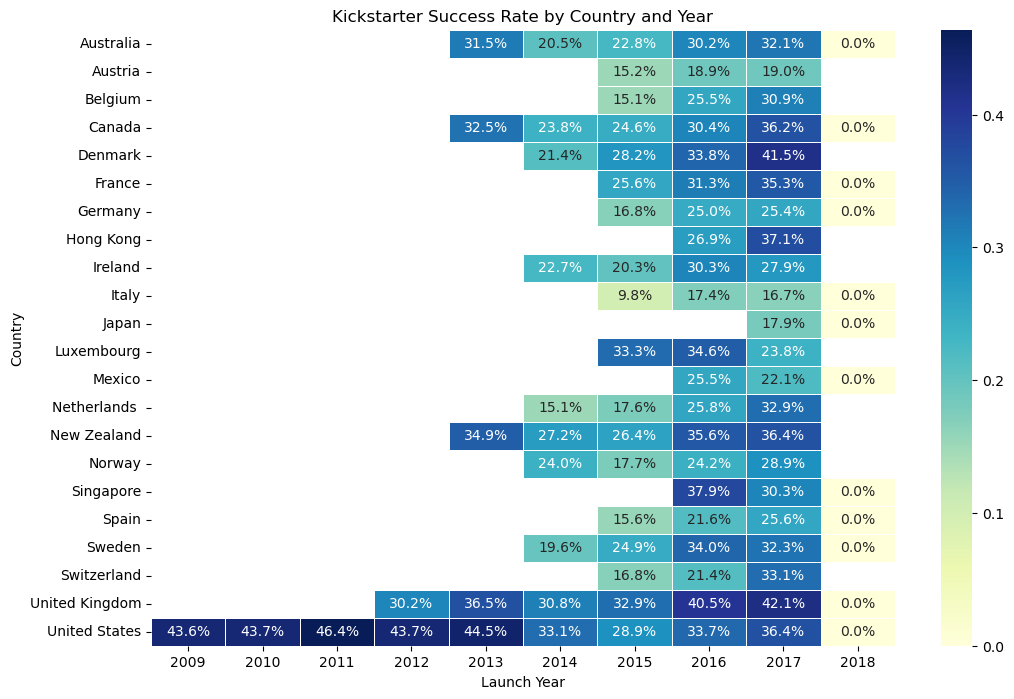

In [23]:
# SUCCESS RATE per country and year

df['Launched'] = pd.to_datetime(df['Launched'], format='%Y-%m-%d %H:%M:%S')
df['Deadline'] = pd.to_datetime(df['Deadline'], format='%Y-%m-%d')

# calculate the time difference between 'deadline' and 'launched' in days
df['Duration'] = (df['Deadline'] - df['Launched']).dt.days

# Convert date columns to datetime
df['Launched'] = pd.to_datetime(df['Launched'])
df['Deadline'] = pd.to_datetime(df['Deadline'])

# Extract the year from Launched
df['Launch_Year'] = df['Launched'].dt.year

# Calculate success rate
# Define successful projects
df['Is_Successful'] = df['State'] == 'Successful'

# Group by Country and Launch_Year and calculate success rate
success_rate_by_country_year = df.groupby(['Country', 'Launch_Year'])['Is_Successful'].mean().reset_index()

# Create a pivot table
pivot_table = success_rate_by_country_year.pivot_table(index='Country', columns='Launch_Year', values='Is_Successful', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".1%", linewidths=.5)
plt.title('Kickstarter Success Rate by Country and Year')
plt.xlabel('Launch Year')
plt.ylabel('Country')
plt.show()

8.2. Success vs. Category

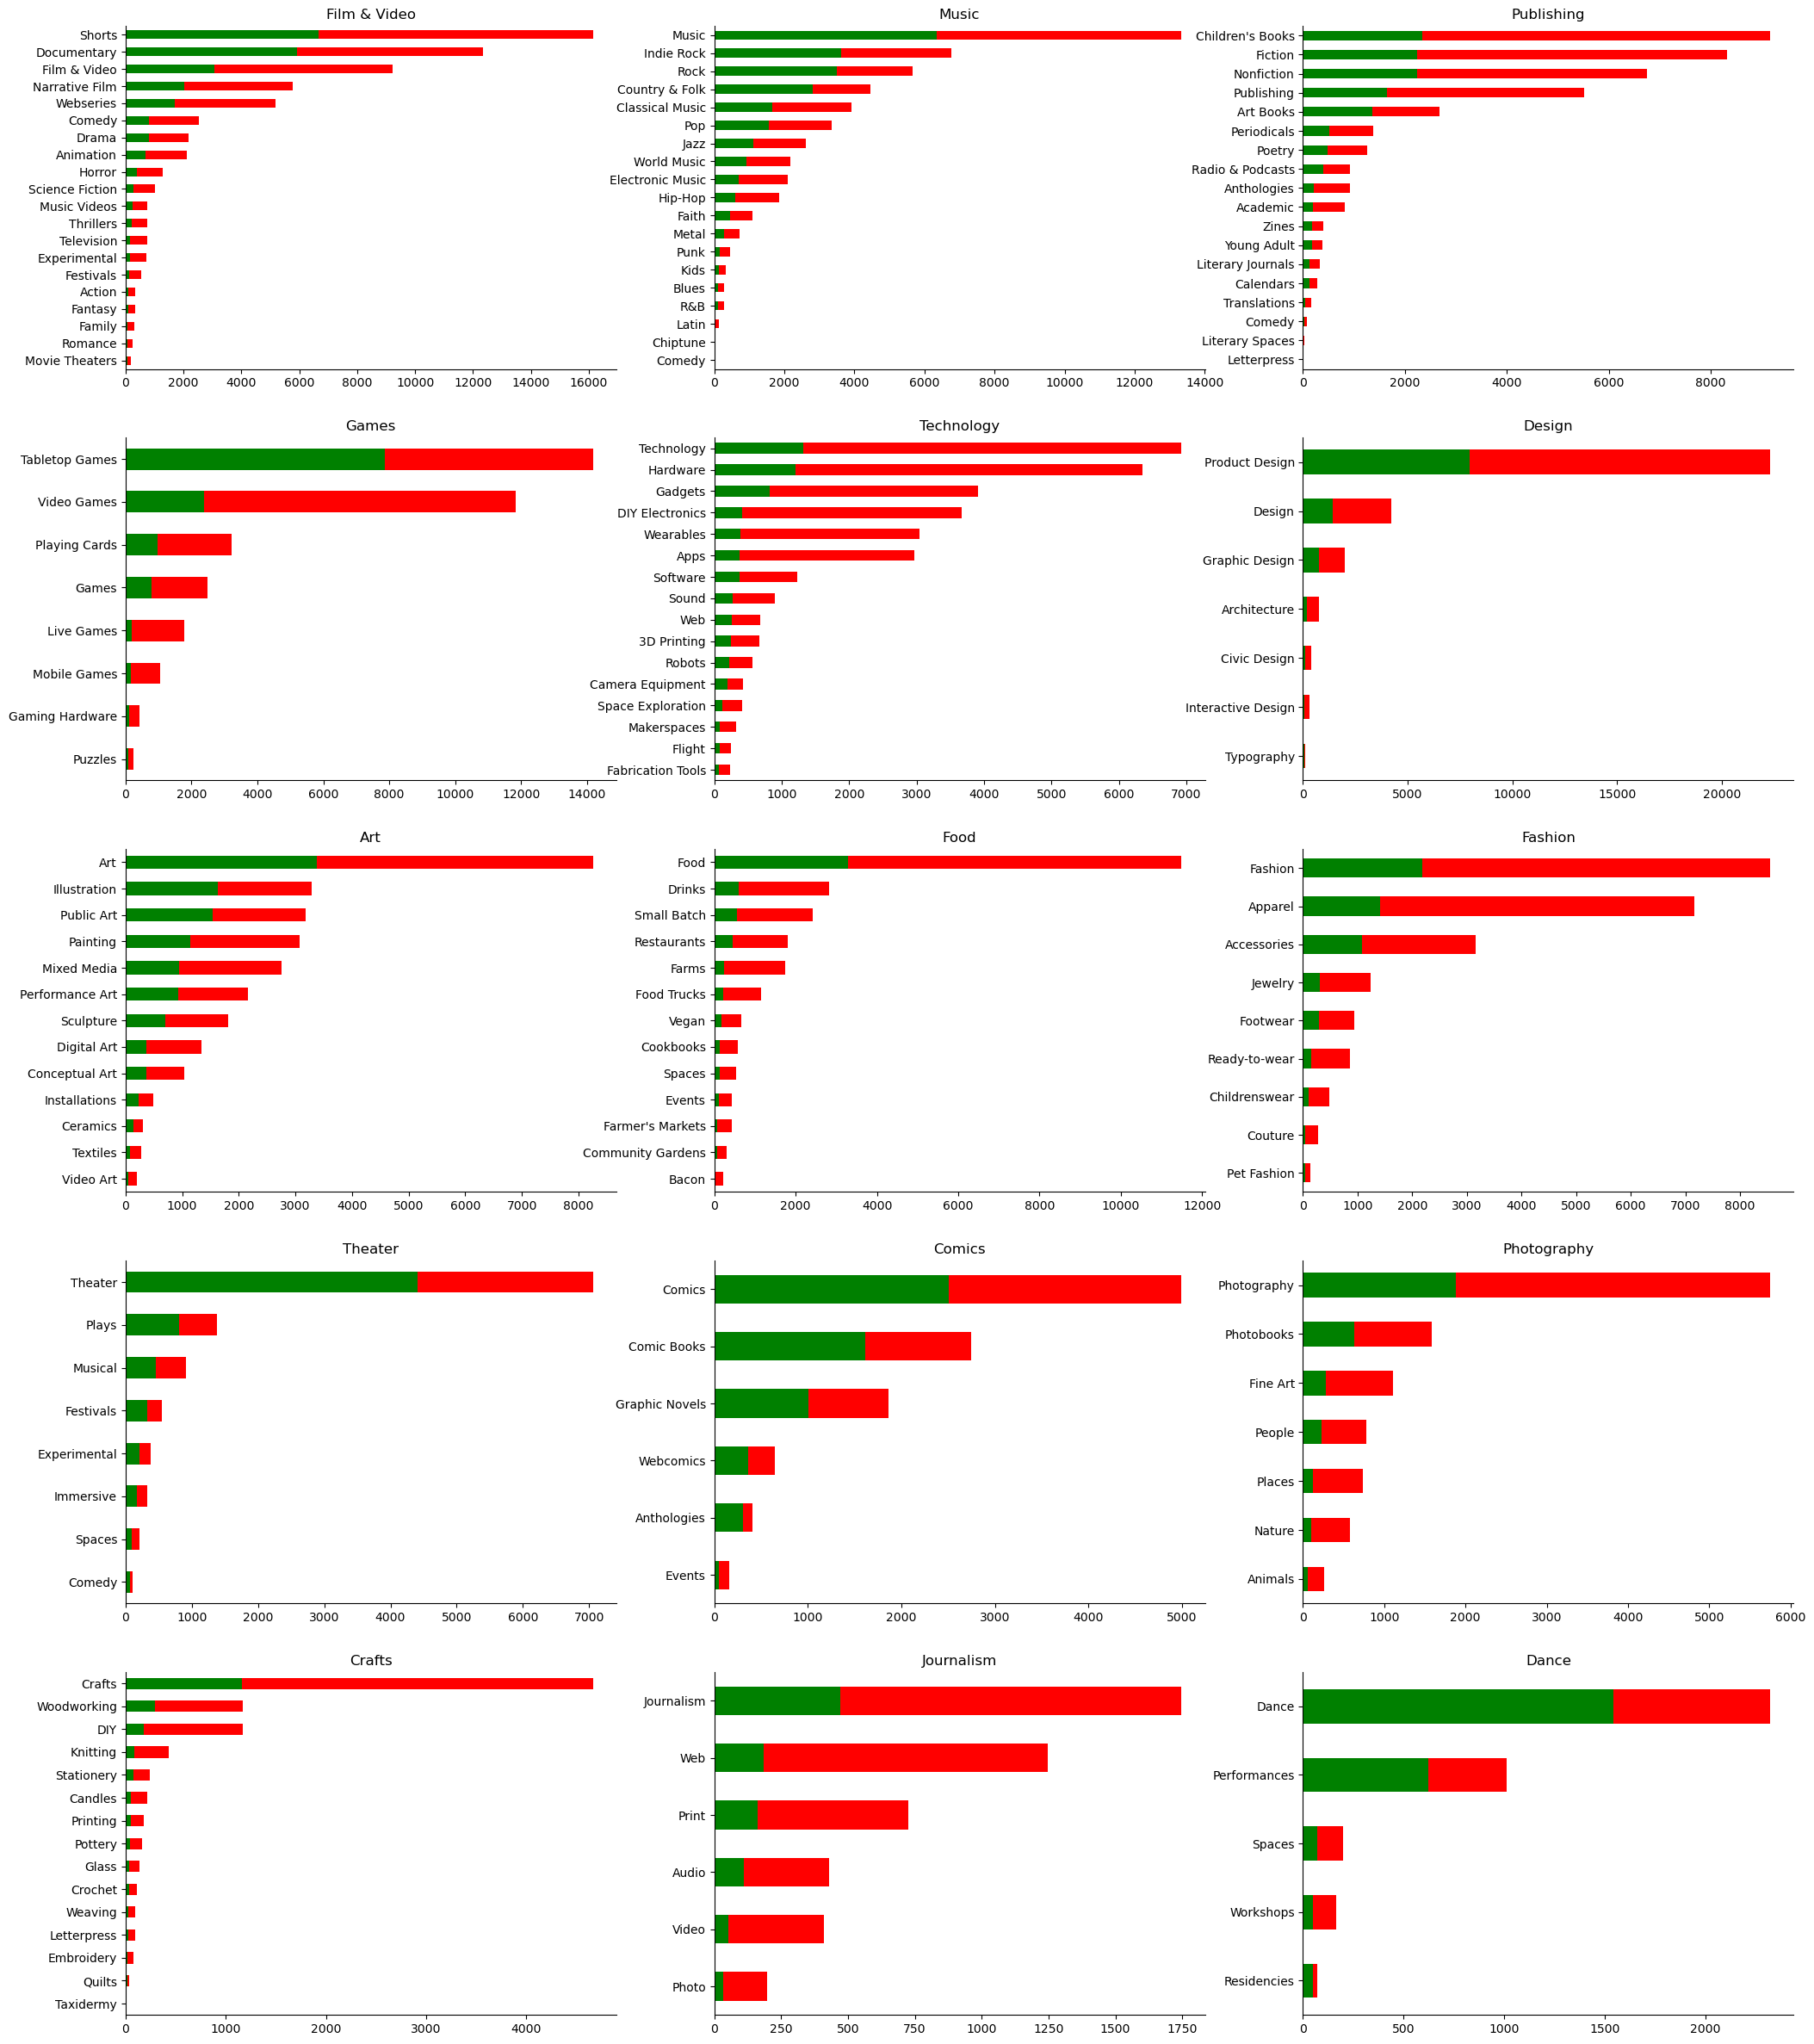

In [24]:
fig, axs = plt.subplots(5, 3, figsize= (25, 30))

for category, ax in zip(df["Category"].value_counts().sort_values(ascending=False).index, axs.flatten()):
    #sns.countplot(df[df["Category"] == category], y="Subcategory", hue="State", ax=ax)
    df[df["Category"] == category]["Subcategory"].value_counts().sort_values().plot(kind="barh", ax=ax, color="red")
    df[df["Category"] == category].query("State == 'Successful'")["Subcategory"].value_counts().sort_values().plot(kind="barh", ax=ax, color="green")
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_title(category)

<Figure size 1000x500 with 0 Axes>

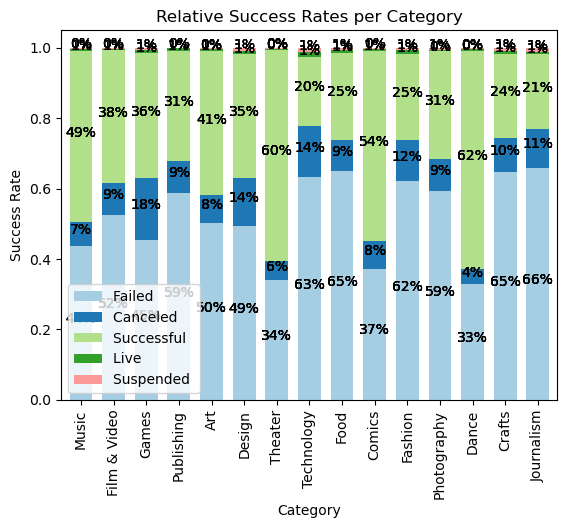

In [25]:
# RELATIVE SUCCESS RATE PER CATEGORY

states = ['Failed', 'Canceled', 'Successful', 'Live', 'Suspended']

# Create a pivot table to calculate the relative success rate per category
pivot_table = df.pivot_table(index='Category', columns='State', aggfunc='size', fill_value=0)

# Calculate the total counts per category
pivot_table['Total'] = pivot_table.sum(axis=1)

# Calculate the relative success rate (Successful / Total) for each state
for state in states:
    pivot_table[f'{state} '] = pivot_table[state] / pivot_table['Total']

# Sort the categories by the success rate of 'Successful' state
sorted_categories = pivot_table['Successful'].sort_values(ascending=False).index
pivot_table = pivot_table.reindex(sorted_categories)

# Plot the relative success rates per category for all states
plt.figure(figsize=(10, 5))
colors = plt.cm.Paired(range(len(pivot_table)))
# Show the legend with a white background
ax = pivot_table[[f'{state} ' for state in states]].plot(kind='bar', stacked=True, color=colors, width=0.7)
plt.title('Relative Success Rates per Category')
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)

# Annotate the bars with percentage values
for state in states:
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        success_rate = p.get_height()
        ax.annotate(f'{success_rate*100:.0f}%', (x + width / 2, y + height / 2), ha='center')

# Enable legend with white background
ax.legend()
ax.get_legend().set_frame_on(True)

plt.show()

8.3. Succes vs. Month of Launch

/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_16984/3031999908.py:17: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,23000,5000)


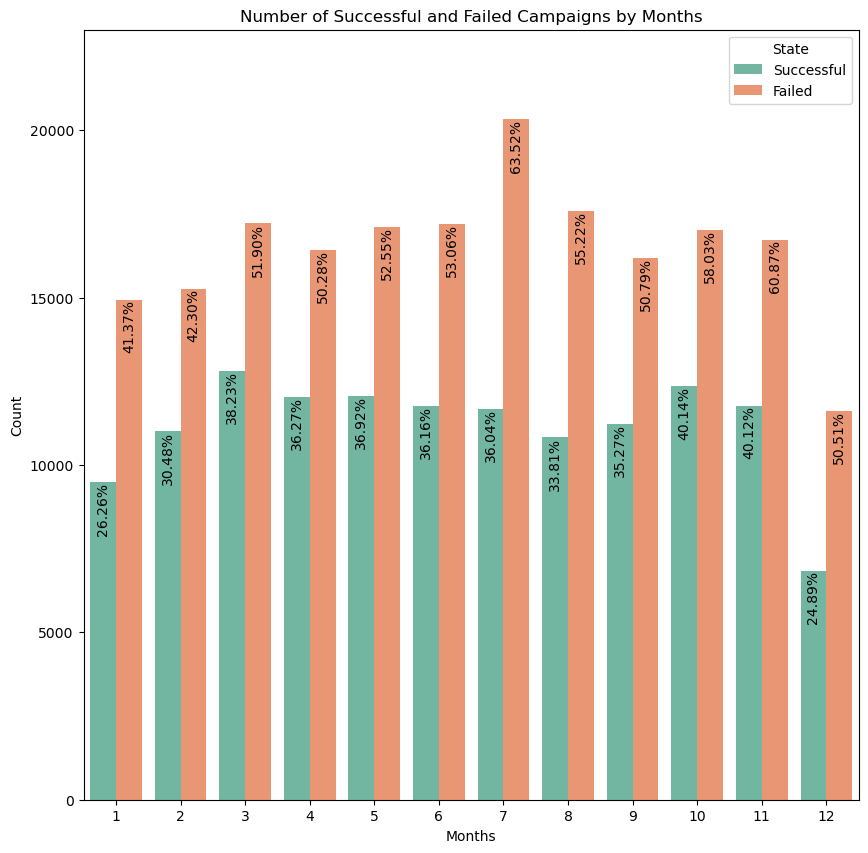

In [27]:
data1 = df.query('State == "Failed" or State == "Successful"')
df["Launched"] = pd.to_datetime(df["Launched"])
df['Month'] = df['Launched'].dt.month
order = df['Month'].value_counts().index
hue_order = ['Successful', 'Failed']
plt.figure(figsize=(10, 10))
ax = sns.countplot(data=df, x='Month', hue='State', palette='Set2', hue_order=hue_order)

# Calculate the relative percentages for each category
category_counts = df['Month'].value_counts()
for p in ax.patches:
    height = p.get_height()
    category = p.get_x()
    ax.text(category + p.get_width() / 2, height + 10 , f'{height / category_counts[order[int(category)]]:.2%}', ha='center', va='top', rotation=90)

# Add labels and title
plt.ylim(0,23000,5000)
plt.ylabel('Count')
plt.xlabel('Months')
plt.title('Number of Successful and Failed Campaigns by Months')
plt.legend(title='State', labels=['Successful','Failed'])
plt.show()

8.4. Success vs. Duration

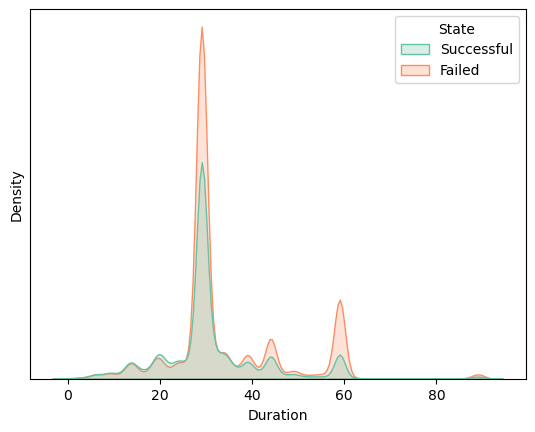

In [28]:
kde = df.query("State == 'Failed' or State == 'Successful'")[["State", "Duration"]]
# kde["Duration"] = kde["Duration"].dt.days

ax = sns.kdeplot(data=kde,
            x="Duration",
            hue="State",
            hue_order=['Successful', 'Failed'],
            palette="Set2",
            fill=True,
            log_scale=[False, False],
            )
plt.yticks([]);

8.5. Success vs. Name (length)

In [29]:
ks['Name_word_count'].nunique()

22

In [30]:
ks['Name_word_count'].unique()

array([ 1,  7,  2,  6,  9,  5,  8, 11,  4,  3, 10, 12, 13, 14, 15, 17, 19,
       16, 27, 21, 18, 29])

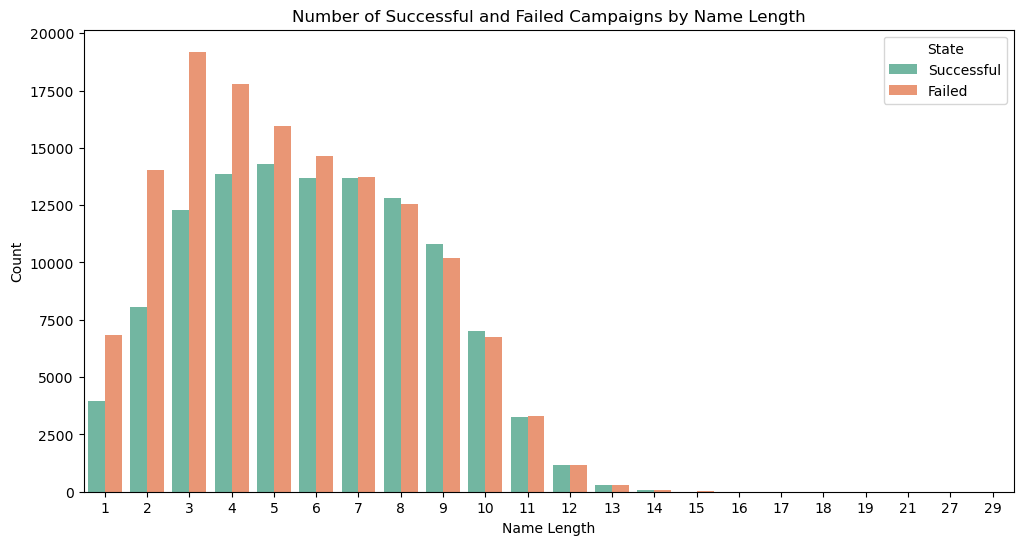

In [31]:
plt.figure(figsize=(12, 6))

# Define a custom hue order to match the legend labels
hue_order = ['Successful', 'Failed']

# Use the 'hue_order' parameter to specify the order of the hue (State) levels
sns.countplot(x='Name_word_count', hue='State', data=ks, palette='Set2', hue_order=hue_order)

plt.xlabel('Name Length')
plt.ylabel('Count')
plt.title('Number of Successful and Failed Campaigns by Name Length')

plt.legend(title='State', labels=['Successful', 'Failed'])
plt.show()

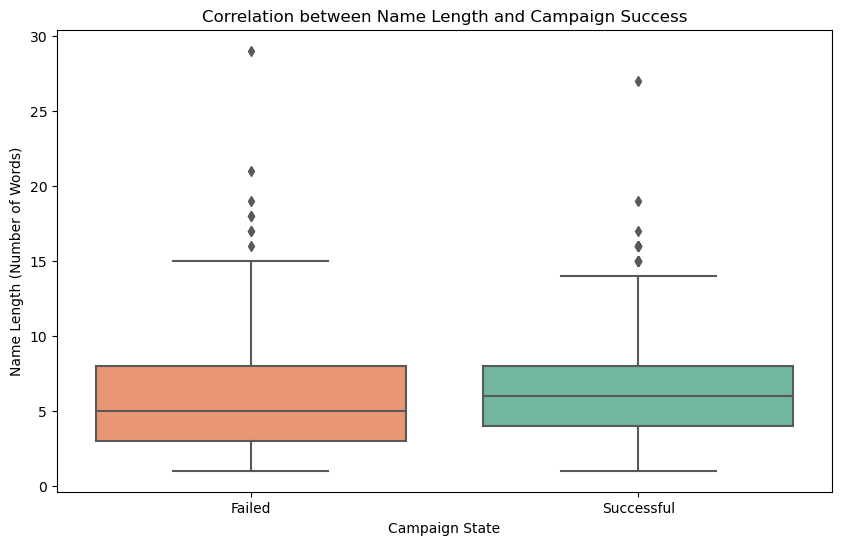

In [32]:
hue_order = ['Failed', 'Successful']
custom_palette = {'Failed': sns.color_palette('Set2')[1], 'Successful': sns.color_palette('Set2')[0]}

plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='Name_word_count', data=ks, palette=custom_palette, hue_order=hue_order)

# Add labels and title
plt.xlabel('Campaign State')
plt.ylabel('Name Length (Number of Words)')
plt.title('Correlation between Name Length and Campaign Success')

plt.show()


---

### 09. Research Results <a name="9"></a>

<a id='results'/>

[TOC](#TOC)

9.1. Is the success of a campaign depending on the country?
<br> YES.
<br>
<br>
9.2. Is the success of a campaign depending on the category?
<br> YES.
<br>
<br>
9.3. Is the success of a campaign depending on the month of launching?
<br> YES.
<br>
<br>
9.4. Is the success of a campaign depending on the duration of the campaign?
<br> YES.
<br>
<br>
9.5. Is the success of a campaign depending on the Name?
<br> NO.
<br>
<br>

---

#### To continue, please select the [Notebook 2 - ML_Model](ML_Model.ipynb).